<a href="https://colab.research.google.com/github/satrio-hw/CapstoneProject_DataMining/blob/master/damin_capstone_0102517023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **R Satrio H Wicaksono (0102517023)**
# Capstone Project Data Mining

Pada capstone Project ini saya akan mencoba untuk melakukan analisis terhadap artikel berita yang didapat dari https://ilps.science.uva.nl/ilps/wp-content/uploads/sites/6/files/bahasaindonesia/.<br><br>
Dari data yang tersedia, saya mengambil data artikel berita kompas dengan detail : <br>


1.   Data di ekstrak dari file dengan ekstensi *.txt*
2.   Data kumpulan artikel tertanggal dari Januari 2001 hingga Desember 2002 (**terkecuali Agustus 2002 dan September 2002**)

3.   Data berupa kumpulan dari total 5449 artikel
4.   Tiap record terdiri dari 'Judul Artikel', 'Tanggal Terbit' dan jumlah frekuensi kemunculan tiap kata dalam artikel tersebut




# Enable CUDA for preprocessing <br>
Untuk melakukan ekstraksi 5449 artikel, saya menggunakan google colab dengan GPU. Dikarenakan jumlah yang besar, artikel akan dikelompokan kedalam 22 folder yang tiap foldernya merepresentasikan bulan terbit artikel didalamnya. Seluruh artikel akan dijadikan dataset sesuai dengan bulan dan tahun terbitnya.<br><br>

Proses ekstraksi juga disertai dengan preprocessing untuk isi artikel. Untuk mempermudah komputasi, proses ini akan dilakukan sebanyak 4 kali dengan tiap waktunya akan memproses 5-6 folder.


---



---



In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Import Library<br>

Library yang digunakan untuk preprocessing adalah nltk, yang nantinya digunakan untuk *tokenization* dan *remove stopwords* pada isi artikel. Library re digunakan untuk mengambil ekspresi regex yang nantinya digunakan untuk menghilangkan semua angka didalam artikel.


---



---



In [2]:
import nltk
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
import string
import re

import os
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
!pip install sastrawi

#Library tambahan
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.metrics import r2_score

sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 215kB 3.3MB/s 


**Library Sastrawi**, digunakan untuk proses *stemming* bahasa Indonesia, dimana tiap kata berimbuhan pada isi artikel akan dikembalikan ke bentuk bakunya untuk kemudian dijadikan token. Hal ini nantinya berfungsi untuk mengurangi *noice* pada dataframe yang dihasilkan


---



---



In [0]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Untuk mempermudah pengambilan data *.txt*, semua data mentah diletakan di google drive


---



---



In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# New Session on GDrive<br>
Untuk tiap kode *authorization* yang diberikan, terdapat batasan waktu tertentu untuk mengakses google drive. Hal ini juga merupakan salah satu alasan ekstraksi dilakukan secara bertahap


---



---



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
root_path = 'gdrive/My Drive/damin_capstone/dataset_berita'

# **GET THE DATA**

## Dataset Artikel 2001-2002

Untuk melakukan analisis yang lebih kaya antar artikel satu dengan lainnya, 22 dataset lainnya akan dibentuk dengan attributes "Judul Artikel", "Tanggal_Terbit", "Isi Artikel", "sum_char_judul" dan "sum_char_isi"

### Dataframe **2001 PERTAMA (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada Januari 2001 - Juni 2001

In [0]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1545
jumlah folder :  6


In [0]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [0]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/maindetail20011notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop maindetail20011notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop maindetail20011notoken_ 022001
loop maindetail20011notoken_ 012001
loop maindetail20011notoken_ 032001
loop maindetail20011notoken_ 042001
loop maindetail20011notoken_ 062001
loop maindetail20011notoken_ 052001
done


### Dataframe **2001 KEDUA (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada Juli 2001 - Desember 2001

In [0]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1615
jumlah folder :  6


In [0]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [0]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/maindetail20012notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop maindetail20012notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop maindetail20012notoken_ 092001
loop maindetail20012notoken_ 102001
loop maindetail20012notoken_ 082001
loop maindetail20012notoken_ 072001
loop maindetail20012notoken_ 122001
loop maindetail20012notoken_ 112001
done


### Dataframe **2002 PERTAMA (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada Juni, Juli, Oktober, November dan Desember 2002

In [0]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1069
jumlah folder :  5


In [0]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [0]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/todataframe20021notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop todataframe20021notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop todataframe20021notoken_ 072002
loop todataframe20021notoken_ 062002
loop todataframe20021notoken_ 102002
loop todataframe20021notoken_ 122002
loop todataframe20021notoken_ 112002
done


### Dataframe **2002 KEDUA (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada Januari 2002 - Mei 2002

In [0]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1220
jumlah folder :  5


In [0]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [0]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/todataframe20022notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop todataframe20022notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop todataframe20022notoken_ 032002
loop todataframe20022notoken_ 012002
loop todataframe20022notoken_ 022002
loop todataframe20022notoken_ 042002
loop todataframe20022notoken_ 052002
done


#**THE PROBLEMS**

Pada Capstone ini saya akan mencoba untuk menjelaskan tentang data timeseries yang berupa artikel berita. Pertanyaan yang ingin dijawab pada akhir project ini adalah :<br>
1. Apakah takaran sebuah artikel berita dapat dikatakan 'mirip' antar satu dengan lainnya bila yang diketahui hanya judul dan isi dari artikel saja?
2. Apakah ada keterkaitan antara panjang artikel dengan frekuensi kemunculan beberapa artikel yang mirip?
3. Apakah ada aturan/pola tersendiri dalam penulisan berita untuk waktu-waktu tertentu?<br>

#**Q1. Apakah takaran sebuah artikel berita dapat dikatakan 'mirip' antar satu dengan lainnya bila yang diketahui hanya judul dan isi dari artikel saja?**<br><br>
Untuk pertanyaan pertama, saya akan menggunakan **_cosine similarity_** sebagai takaran kemiripan antar artikel. Mengingat gaya penulisan yang beragam, akan ada kemungkinan kata yang kurang begitu penting memiliki frekuensi lebih dibandingkan dengan kata kunci pada artikel. Oleh karena itu saya menggunakan **Bag of Words** dengan nilai **binary**. BoW menyatakan apakah sebuah kata dalam sebuah artikel juga terdapat di artikel lainnya. Semakin banyak kata yang beririsan antar artikel, semakin mirip kedua artikel tersebut.<br><br>

Cosine Similarity menghasilkan produk skalar dalam metrix NxN, dimana tiap bagiannya berisi value **0.0-1.0**. Mengingat pula dikarenakan penulisan artikel yang terkesan bebas, perlu adanya acuan _Boundary Value_ yang akan digunakan sebagai pembanding hasil Cosine Similarity nantinya.<br>

Untuk itu, saya mencoba mencari nilai cosine similarity dari 6 artikel CNN yang bertemakan tentang banjir di Jakarta pada Januari 2020. Artikel ini diambil dan dituliskan kembali secara manual dan melalui proses baik stemming, tokenizing dll yang identik dengan data set yang nantinya dijadikan objek pengamatan. Keenam artikel diupload pada hari yang sama (2/1/2020). File berupa format _.txt_ dengan konten isi artikel saja.

In [7]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/cnn/'):
  count+=1
  #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  6
jumlah folder :  6


In [0]:
main_df = pd.DataFrame()
for txtfile in os.listdir('/content/drive/My Drive/damin_capstone/cnn/'):
  """ Open file """
  f=open(('/content/drive/My Drive/damin_capstone/cnn/'+txtfile),"rb")
  isifile=f.read()
  textisi=str(isifile)
    
  textisi=textisi.strip('\\n') #remove trailing newline
  textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
  textisi = re.sub(r"\d+", "", textisi) #remove number
    
  textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols
  temp=pd.DataFrame({'isi_artikel':[textisi]})
  main_df=main_df.append(temp, ignore_index=True, sort=True)

In [9]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)

vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(main_df['isi_artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

display(cosine_similarity(bow_matrix))
ratarata=((cosine_similarity(bow_matrix).sum())-6)/30
print('\nrata-rata cosine sim. dari keenam artikel : ',ratarata)

Feature dengan Tambahan nltk:  500


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,age,agus,air,akademika,akibat,akses,aktivitas,alam,alat,alumni,anak,anggrek,angkutan,api,arah,arahan,area,argo,armada,arus,aturan,awak,awan,awanawan,ayu,badan,bahan,bala,balai,balita,banjir,banjirrnrnmenurut,banjirrnrntak,bantuan,banyaknya,barang,barat,bekasi,bekasirnrnwarga,bekti,...,tersebutrnrnkami,tersedia,tersengat,terseret,tertimbun,tertutupnya,tibarnrnsejumlah,tikar,tim,timnya,timur,tindakan,tinggalnya,tinggalrnrnwakil,tinggirnrnya,titik,toilet,tol,ton,tri,trirnrnpihaknya,tujuh,turi,turun,ujarnyarnrnbeberapa,ujarnyarnrnkepala,universitas,untar,upaya,utama,warga,wib,wibowo,wibrnrnsebelumnya,wilayah,wilayahnya,yitro,yogyakarta,yogyakartarnrnmeskipun,zunantarnrnmenurut
0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,...,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0
2,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1


array([[1.        , 0.0993808 , 0.08018754, 0.08333333, 0.07290148,
        0.10825318],
       [0.0993808 , 1.        , 0.12431798, 0.26501546, 0.16518617,
        0.11475506],
       [0.08018754, 0.12431798, 1.        , 0.17106675, 0.05611959,
        0.09259259],
       [0.08333333, 0.26501546, 0.17106675, 1.        , 0.11664237,
        0.11226255],
       [0.07290148, 0.16518617, 0.05611959, 0.11664237, 1.        ,
        0.12626907],
       [0.10825318, 0.11475506, 0.09259259, 0.11226255, 0.12626907,
        1.        ]])


rata-rata cosine sim. dari keenam artikel :  0.11921892785169745


Dari perhitungan diatas, untuk kasus ini dapat diasumsikan bahwa artikel dengan nilai **cosine similarity $\approx$ 0.12** sudah dapat dikatakan memiliki kemiripan tema antar satu dengan lainnya

## Load dataset

In [0]:
csv_path = '/content/drive/My Drive/damin_capstone/dataset_berita/kompas/csv_files/notoken'

In [11]:
count=0
for files in os.listdir(csv_path):
  count+=1
print('jumlah file : ',count)

jumlah file :  22


In [0]:
pd.set_option('display.max_rows', 15)

df2001 = pd.DataFrame()
df2002 = pd.DataFrame()
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()

idx=0
for files in os.listdir(csv_path):
  if str(files).find('2001') != -1:
    temp1=pd.read_csv(csv_path+'/'+files)
    df2001= df2001.append(temp1, ignore_index=True)

  elif str(files).find('2002') !=-1:
    temp2=pd.read_csv(csv_path+'/'+files)
    df2002= df2002.append(temp2, ignore_index=True)
  else:
    print('not included: ', files)


In [13]:
df2001['Tanggal_Terbit']=pd.to_datetime(df2001['Tanggal_Terbit'])
df2002['Tanggal_Terbit']=pd.to_datetime(df2002['Tanggal_Terbit'])
df2001.columns=['Index_artikel','Isi_Artikel',	'Judul_Artikel',	'Tanggal_Terbit',	'len_Isi_Artikel',	'len_Judul']
df2002.columns=['Index_artikel','Isi_Artikel',	'Judul_Artikel',	'Tanggal_Terbit',	'len_Isi_Artikel',	'len_Judul']

df2001=df2001.sort_values(by=['Tanggal_Terbit', 'Index_artikel'], ascending=[True, True])
df2002=df2002.sort_values(by=['Tanggal_Terbit', 'Index_artikel'], ascending=[True, True])

print('Menampilkan info untuk dataset yang di load (kedua dataset identik):')
display(df2001.info())
print('\nDATASET ARTIKEL 2001')
display(df2001.head())
display(df2002.info())
print('\nDATASET ARTIKEL 2002')
display(df2002.head())

Menampilkan info untuk dataset yang di load (kedua dataset identik):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 6 columns):
Index_artikel      3160 non-null int64
Isi_Artikel        3160 non-null object
Judul_Artikel      3160 non-null object
Tanggal_Terbit     3160 non-null datetime64[ns]
len_Isi_Artikel    3160 non-null int64
len_Judul          3160 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 172.8+ KB


None


DATASET ARTIKEL 2001


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
0,0,lima orang tewas dan sekitar cedera di antar...,Api dan Bom Sambut Awal Milenium Baru,2001-01-02,4836,37
1,1,presiden abdurrahman wahid mengatakan di balik...,Pertumbuhan Ekonomi Lebih Baik dari Perkiraan,2001-01-02,6212,45
2,2,upaya melly sebut saja begitu siasia bunyi ya...,Harapan Tahun Baru dari Tepian Rel,2001-01-02,5118,34
3,3,malam pergantian tahun dari ke di jakarta se...,Malam Pergantian Tahun Berlangsung Aman,2001-01-02,5943,39
4,4,suasana pergantian tahun diwarnai peristiwa tr...,"Bus Sinar Jaya Hantam Minibus, 10 Orang Tewas",2001-01-02,2911,45


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 1069 to 1068
Data columns (total 6 columns):
Index_artikel      2289 non-null int64
Isi_Artikel        2289 non-null object
Judul_Artikel      2289 non-null object
Tanggal_Terbit     2289 non-null datetime64[ns]
len_Isi_Artikel    2289 non-null int64
len_Judul          2289 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 125.2+ KB


None


DATASET ARTIKEL 2002


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
1069,0,sebagian besar bursa utama dunia menutup trans...,Bursa Dunia Ditutup Terpuruk,2002-01-02,5619,28
1070,1,jabatan presiden di argentina saat ini nyaris ...,Presiden Rodriguez Saa Mundur Argentina Cari ...,2002-01-02,3942,59
1071,2,pemerintah daerah pemda dki jakarta dan badan ...,"Disepakati, Gunakan Marunda sebagai TPA",2002-01-02,3691,39
1072,3,pemerintah memastikan akan menaikkan tarif das...,Tarif Listrik Naik Enam Persen Per 1 Janua...,2002-01-02,6493,53
1073,4,dana kemanusiaan kompas dkk yang disalurkan ke...,DKK Salurkan Rp 148.400.000 pada November 2001,2002-01-02,1793,46


**_Haruskah dilakukan analisis terpisah antara panjang isi artikel dengan panjang judul ?_**

Untuk menjawab pertanyaan tersebut, saya mencoba untuk mencari korelasi antara kedua atribut tersebut.

In [15]:
othertemp=df2001.iloc[:,4:]
othertemp.corr()
othertemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 2 columns):
len_Isi_Artikel    3160 non-null int64
len_Judul          3160 non-null int64
dtypes: int64(2)
memory usage: 74.1 KB


In [16]:
othertemp=df2002.iloc[:,4:]
othertemp.corr()
othertemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 1069 to 1068
Data columns (total 2 columns):
len_Isi_Artikel    2289 non-null int64
len_Judul          2289 non-null int64
dtypes: int64(2)
memory usage: 53.6 KB


In [17]:
othertemp_comb=df2001.iloc[:,4:]
othertemp_comb=othertemp_comb.append(df2002.iloc[:,3:],sort=True)
othertemp_comb.corr()

,len_Isi_Artikel,len_Judul
len_Isi_Artikel,1.000000,0.123289
len_Judul,0.123289,1.000000


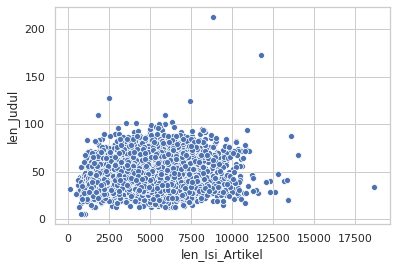

In [18]:
sns.scatterplot(x=othertemp_comb['len_Isi_Artikel'], y=othertemp_comb['len_Judul'])

di dalam dataframe, baik tahun 2001, 2002 ataupun gabungan keduanya, korelasi antara panjang judul dan panjang artikel amat lemah. Berdasarkan hasil tersebut, dapat dikatakan bahwa analisis panjang isi artikel dengan panjang judul dapat dilakukan secara _terpisah/independen satu dengan yang lain_.

#**Q2. Apakah ada keterkaitan antara panjang artikel dengan frekuensi kemunculan beberapa artikel yang mirip?**

## ANALISIS BERDASARKAN PANJANG ARTIKEL

Bentuk distribusi data untuk panjang artikel akan digambarkan sesuai dengan bulan terbitnya artikel. Visualisasi ini ditujukan untuk lebih mengetahui pendekatan analisis menggunakan *mean atau median* yang lebih baik dilakukan. Bila distribusi mendekati distribusi normal, maka penggunaan mean atau median sebagai penggambaran representasi data tidak membawa dampak segnifikan terhadap hasil analisis. Akan tetapi untuk distribusi dengan 'long tail' dengan selisih mean dan median yang cukup segnifikan, dapat berpengaruh terhadap asumsi terhadap data keseluruhan


### **Mean atau Median?**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


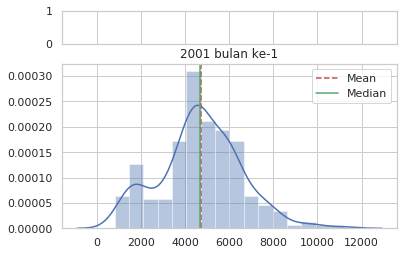

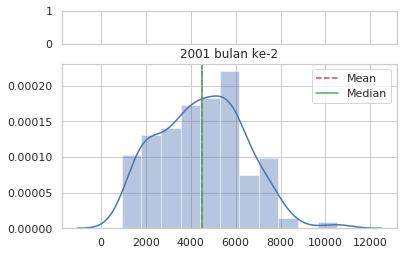

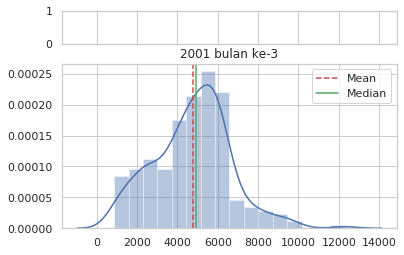

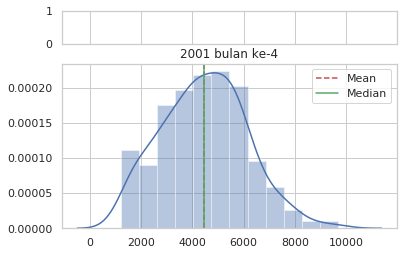

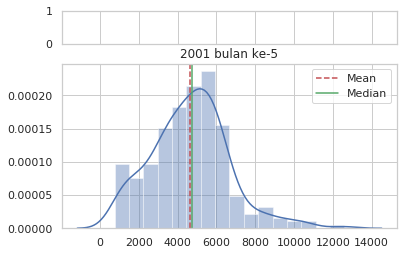

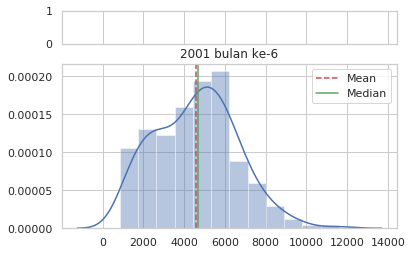

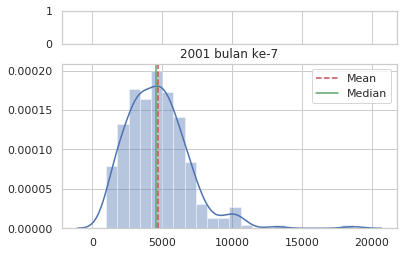

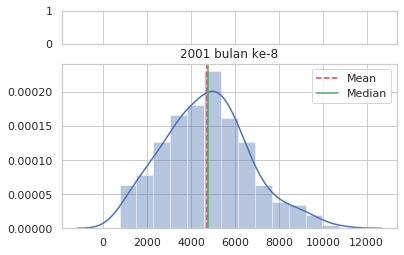

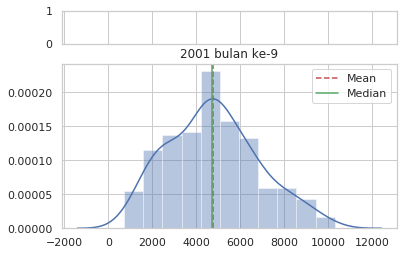

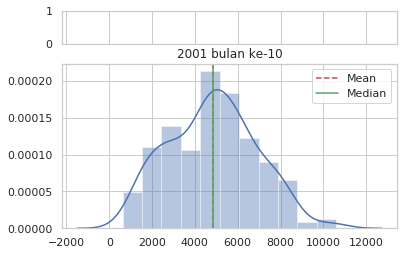

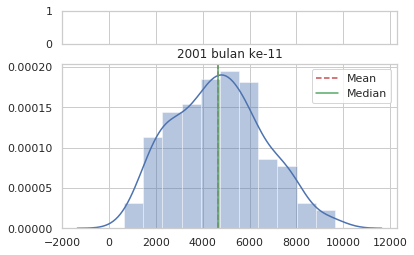

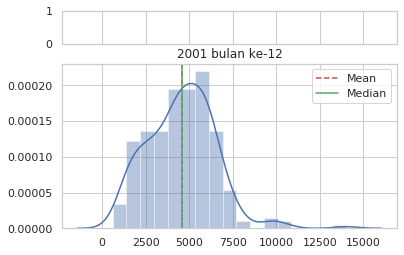

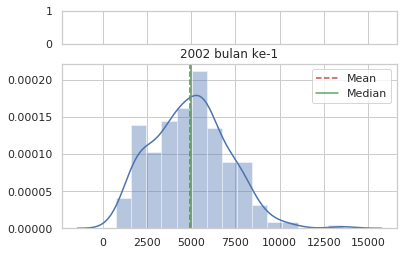

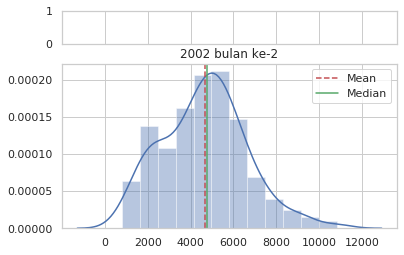

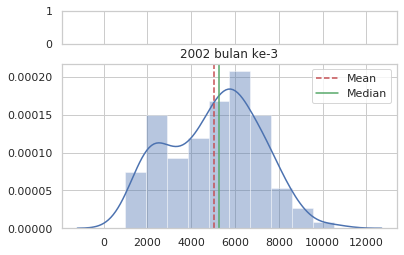

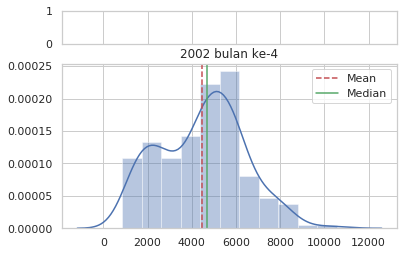

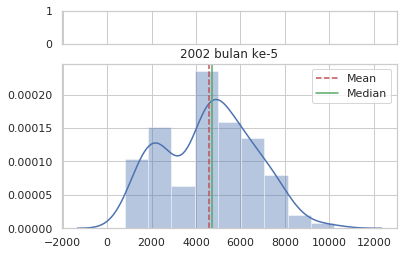

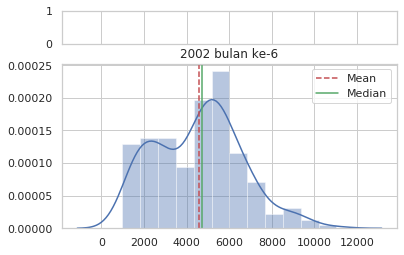

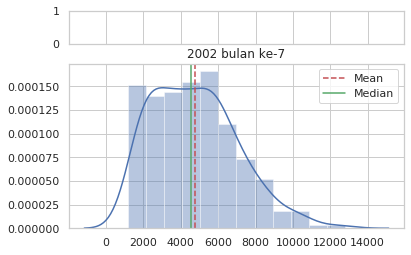

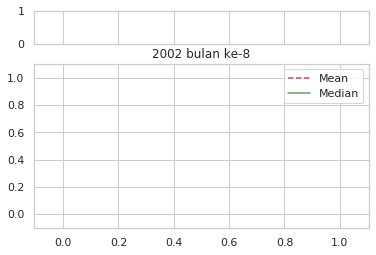

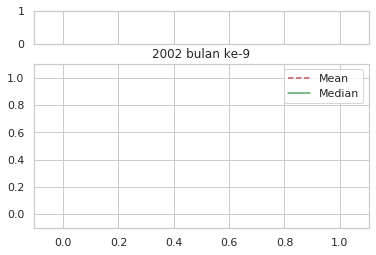

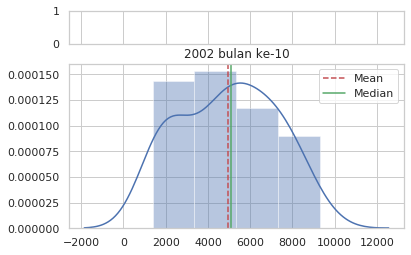

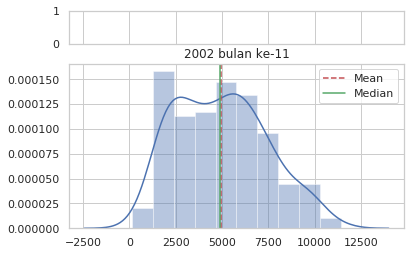

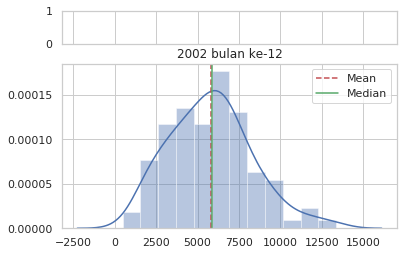

In [19]:
for i in range(1,13):
  #print('Bulan ke-',i)
  mask = (df2001['Tanggal_Terbit'].dt.month==i)
  temp=df2001.loc[mask]
  temp=temp.loc[:,['len_Isi_Artikel']]
  #display(temp)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
  mean=temp['len_Isi_Artikel'].mean()
  median=temp['len_Isi_Artikel'].median()

  temp_plot=sns.distplot(temp, ax=ax_hist)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle='-')
  temp_plot.set(title=('2001 bulan ke-%d'%i))
  
  plt.legend({'Mean':mean,'Median':median})

for i in range(1,13):
  #print('Bulan ke-',i)
  mask = (df2002['Tanggal_Terbit'].dt.month==i)
  temp=df2002.loc[mask]
  temp=temp.loc[:,['len_Isi_Artikel']]
  #display(temp)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
  mean=temp['len_Isi_Artikel'].mean()
  median=temp['len_Isi_Artikel'].median()

  temp_plot=sns.distplot(temp, ax=ax_hist)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle='-')
  temp_plot.set(title=('2002 bulan ke-%d'%i))
  
  plt.legend({'Mean':mean,'Median':median})

Dari visualisasi diatas, dapat dilihat bahwa untuk distribusi tiap bulannya, baik mean maupun mediannya tidak terpisah secara segnifikan. Dalam kasus ini, saya menggunakan mean sebagai parameter yang akan digunakan sepanjang proses analisis, mengingat distrubusi data yang *mendekati* normal

perlu diingat bahwa pada tahun 2002, tidak tersedia data untuk bulan Agustus dan September, sehingga perlu dihilangkan pada analisis nantinya

### **Mean Panjang Artikel**

In [20]:
lenartikel_2001=df2001.loc[:,['len_Isi_Artikel']]
lenartikel_2001.index=df2001['Tanggal_Terbit']  #dataframe 'lenartikel_2001' berisi jumlah karakter pada tiap isi artikel tahun 2001 dengan tanggal sebagai indexnya

lenartikel_2001_mean=lenartikel_2001.resample('M').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

lenartikel_2002=df2002.loc[:,['len_Isi_Artikel']]
lenartikel_2002.index=df2002['Tanggal_Terbit']  #dataframe 'lenartikel_2002' berisi jumlah karakter pada tiap isi artikel tahun 2002 dengan tanggal sebagai indexnya

lenartikel_2002_mean=lenartikel_2002.resample('M').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

display(lenartikel_2001_mean.describe())
display(lenartikel_2002_mean.describe())

,len_Isi_Artikel
count,12.000000
mean,4653.488865
std,112.416809
min,4463.835206
25%,4572.926397
50%,4662.521552
75%,4722.618640
max,4830.780669


,len_Isi_Artikel
count,10.000000
mean,4871.623713
std,381.968694
min,4462.129707
25%,4609.523598
50%,4845.655027
75%,4962.332223
max,5799.029126


untuk mengetahui perbandingan panjang artikel sepanjang 2001 hingga 2002 lebih jelas, saya mencoba untuk membuat bar-plot dan perbandingan korelasinya tiap tahun

In [22]:
ls2001_mean=[]
for i in list(lenartikel_2001_mean.values):
  ls2001_mean.append(i[0])

ls2002_mean=[]
for i in list(lenartikel_2002_mean.values):
  ls2002_mean.append(i[0])

meanpermonth=pd.DataFrame({'Month':['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Aug','Sept','Oct','Nov','Des'],
                           '2001':ls2001_mean,
                           '2002':ls2002_mean})
display(meanpermonth)

,Month,2001,2002
0,Jan,4701.444030,4954.573077
1,Feb,4487.159184,4649.781893
2,Mar,4748.338710,5038.121849
3,Apr,4463.835206,4462.129707
4,Mei,4649.599206,4596.104167
5,Jun,4573.969811,4560.268657
6,Jul,4664.780142,4749.185053
7,Aug,4714.045283,NaN
8,Sept,4777.855019,NaN
9,Oct,4830.780669,4942.125000


In [23]:
barplot_meanpermonth=pd.melt(meanpermonth, id_vars=['Month'], value_vars=['2001','2002'], var_name='Year', value_name='Mean of articles length')
barplot_meanpermonth.head()

,Month,Year,Mean of articles length
0,Jan,2001,4701.444030
1,Feb,2001,4487.159184
2,Mar,2001,4748.338710
3,Apr,2001,4463.835206
4,Mei,2001,4649.599206


### Tentang Korelasi
<a id='korelasi_perbulan'></a>

[Text(0.5, 1, 'Correlation of means for 2001 and 2002 (August and October excluded)')]

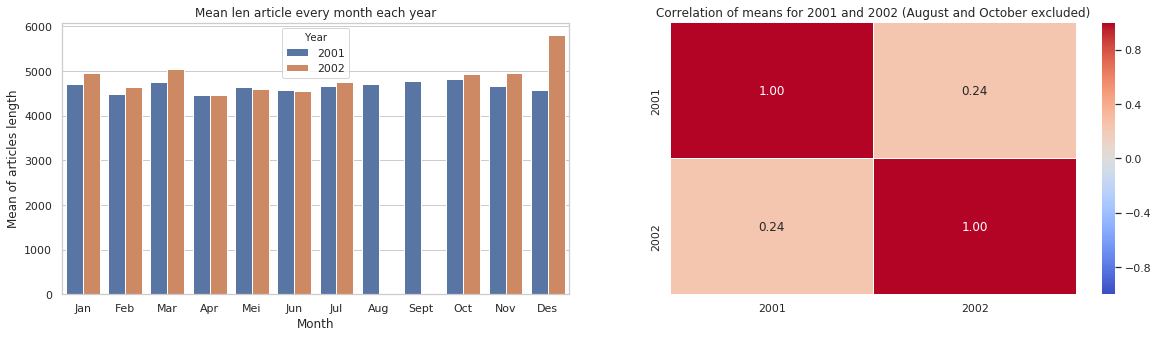

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
mean_bar=sns.barplot(x='Month', y='Mean of articles length', hue='Year', data=barplot_meanpermonth)
mean_bar.set(title="Mean len article every month each year")

plt.subplot(1,2,2)
df_for_corr=meanpermonth.iloc[:7,:]
df_for_corr=df_for_corr.append(meanpermonth.iloc[9:,:])
mean_coor = sns.heatmap(round(df_for_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor.set(title="Correlation of means for 2001 and 2002 (August and October excluded)")

Korelasi rata-rata panjang artikel perbulan selama 2 tahun cukup kecil secara keseluruhan, akan tetapi dapat dilihat bahwa pada bulan Desember 2002 terdapat lonjakan rata-rata panjang artikel.<br><br>
Untuk mengetahui apakah lonjakan ini cukup segnifikan, saya mencoba untuk menghilangkan bulan Desember dari tabel, sehingga diperoleh hasil :

[Text(0.5, 1, 'Corr means (August, October and December excluded)')]

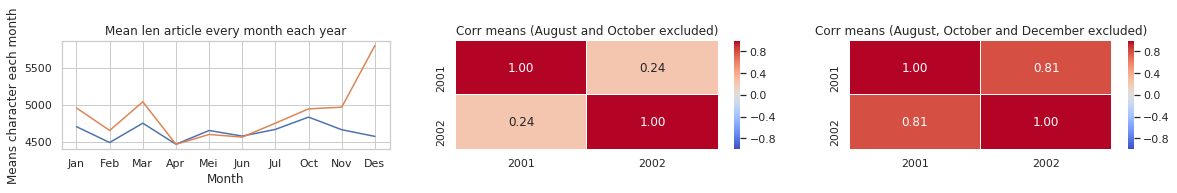

In [29]:
plt.figure(figsize=(20,2))
plt.subplot(1,3,1)
line_plt=sns.lineplot(x='Month', y='2001',data=df_for_corr, sort=False)
line_plt=sns.lineplot(x='Month', y='2002',data=df_for_corr, sort=False)
line_plt.set(title="Mean len article every month each year", ylabel='Means character each month')

plt.subplot(1,3,2)
df_for_corr1=meanpermonth.iloc[:7,:]
df_for_corr1=df_for_corr1.append(meanpermonth.iloc[9:,:]) #dataframe tanpa bulan agustus dan september
mean_coor = sns.heatmap(round(df_for_corr1.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor.set(title="Corr means (August and October excluded)")

plt.subplot(1,3,3)
df_for_corr2=meanpermonth.iloc[:7,:]
df_for_corr2=df_for_corr2.append(meanpermonth.iloc[9:11,:]) #dataframe tanpa bulan agustus, september, desember
mean_coor_nodes = sns.heatmap(round(df_for_corr2.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor_nodes.set(title="Corr means (August, October and December excluded)")

<a id='barplot_mean'></a>Jika bulan Desember diabaikan, maka korelasi panjang artikel kedua tahun tersebut **bertambah** pesat dari 0.24 menjadi 0.81.<br>
Selanjutnya, saya mencoba mencaritahu apakah hal ini berlaku hanya pada penghilangan variabel 'Desember' dari persamaan, atau berlaku untuk semua bulan

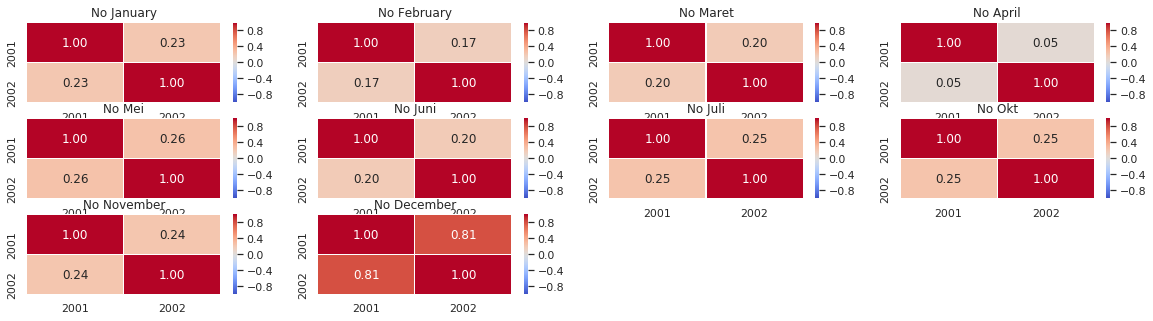

In [30]:
plt.figure(figsize=(20,5))

plt.subplot(3,4,1)
#No January
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jan']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No January")

plt.subplot(3,4,2)
#No February
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Feb']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No February")

plt.subplot(3,4,3)
#No Maret
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Mar']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Maret")

plt.subplot(3,4,4)
#No April
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Apr']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No April")

plt.subplot(3,4,5)
#No Mei
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Mei']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Mei")

plt.subplot(3,4,6)
#No Juni
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jun']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Juni")

plt.subplot(3,4,7)
#No Juli
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jul']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Juli")

plt.subplot(3,4,8)
#No Okt
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Oct']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Okt")

plt.subplot(3,4,9)
#No November
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Nov']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No November")

plt.subplot(3,4,10)
df_for_corr2=meanpermonth.iloc[:7,:]
df_for_corr2=df_for_corr2.append(meanpermonth.iloc[9:11,:]) #dataframe tanpa bulan agustus, september, desember
mean_coor_nodes = sns.heatmap(round(df_for_corr2.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No December")

Dari perbandingan data mean panjang artikel untuk tahun 2001 dan 2002 selama 9 bulan (dengan asumsi Agustus dan September selalu tidak disertakan), diperoleh hasil bahwa perubahan korelasi yang cukup segnifikan *hanya* terjadi bila bulan Desember dihilangkan dari persamaaan.

### **Analisis Anomali Data Panjang Artikel**

Saya mencoba untuk mendapatkan gambaran tentang data outlier dengan menggunakan box-plot

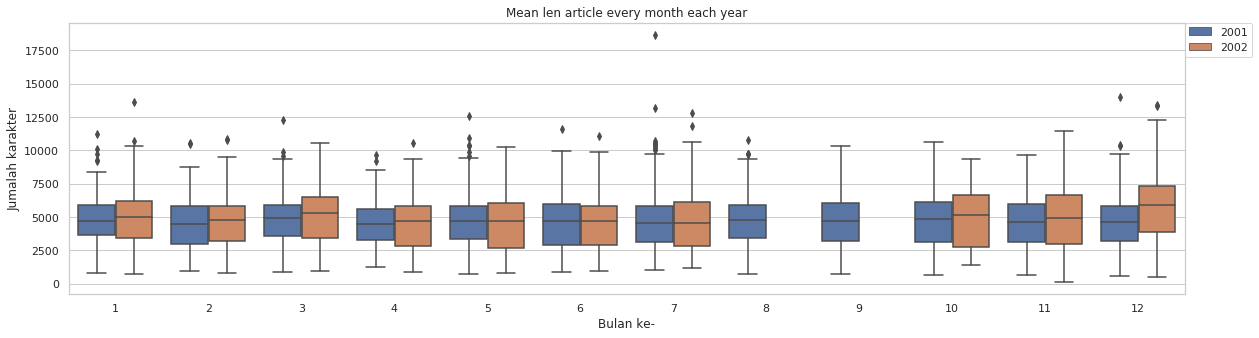

In [31]:
boxplot_lenartikel_allyear=lenartikel_2001
boxplot_lenartikel_allyear=boxplot_lenartikel_allyear.append(lenartikel_2002)
#display(boxplot_lenjudul)

plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
mean_bar=sns.boxplot(x=boxplot_lenartikel_allyear.index.month , y='len_Isi_Artikel', hue=boxplot_lenartikel_allyear.index.year, data=boxplot_lenartikel_allyear)
mean_bar.set(title="Mean len article every month each year")
mean_bar.set(xlabel='Bulan ke-', ylabel='Jumalah karakter')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

meskipun data yang paling berpengaruh di korelasi antar tahun berada di bulan Desember, ternyata outlier terbesar justru terletak di bulan Juli.<br><br>
Kembali ke analisis awal seputar bulan desember. Bila dipisahkan dari bulan-bulan yang lain, kita dapat memperoleh box plot seperti berikut

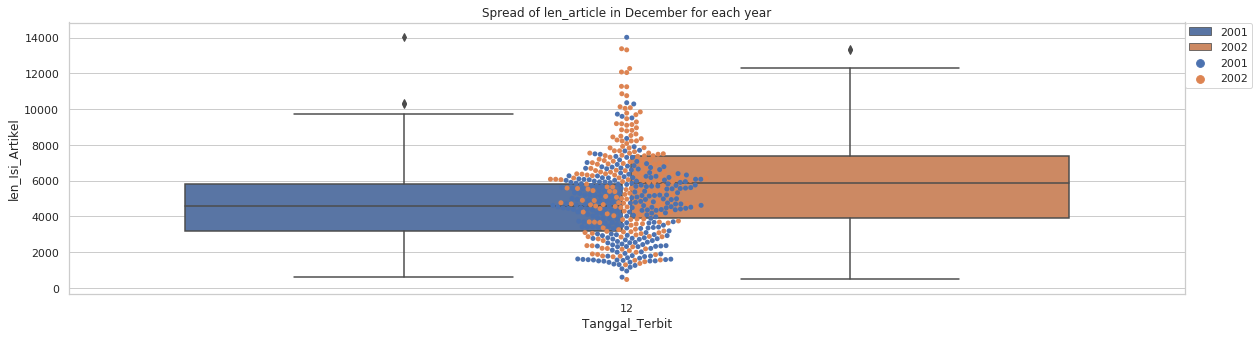

In [32]:
boxplot_lenartikel2001=lenartikel_2001.iloc[(lenartikel_2001.index.month)==12,:]
#display(boxplot_lenartikel2001.describe())
boxplot_lenartikel2002=lenartikel_2002.iloc[(lenartikel_2002.index.month)==12,:]
#display(boxplot_lenartikel2002.describe())

boxplot_lenartikel=boxplot_lenartikel2001
boxplot_lenartikel=boxplot_lenartikel.append(boxplot_lenartikel2002)


plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
mean_box=sns.boxplot(x=boxplot_lenartikel.index.month , y='len_Isi_Artikel', hue=boxplot_lenartikel.index.year, data=boxplot_lenartikel)
mean_box.set(title="Spread of len_article in December for each year")
mean_box.set(xlabel='Bulan ke-', ylabel='Jumalah karakter')
mean_box=sns.swarmplot(x=boxplot_lenartikel.index.month , y='len_Isi_Artikel', hue=boxplot_lenartikel.index.year, data=boxplot_lenartikel)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

Dari box-plot tersebut, kita tahu bahwa *outlier tahun 2001* memiliki nilai diatas $\approx$ 9,800, sementara *outlier tahun 2002* memiliki nilai diatas $\approx$ 12,200. Selanjutnya adalah mendapatkan artikel apa saja yang termasuk dalam outlier

In [34]:
print('Tahun 2001')
getoutliersDes2001= df2001.loc[df2001['len_Isi_Artikel']>9800]
getoutliersDes2001=getoutliersDes2001[getoutliersDes2001['Tanggal_Terbit'].dt.month==12]
display(getoutliersDes2001)
display(getoutliersDes2001.describe())

print('\nTahun 2002')
getoutliersDes2002= df2002.loc[df2002['len_Isi_Artikel']>12200]
getoutliersDes2002=getoutliersDes2002[getoutliersDes2002['Tanggal_Terbit'].dt.month==12]
display(getoutliersDes2002)
display(getoutliersDes2002.describe())

Tahun 2001


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
3000,100,ulasan minggu ini mau tak mau bersifat amat mi...,"ANALISIS EKONOMI SJAHRIR Kebijakan Mikro, d...",2001-12-10,10293,68
3043,143,transaksi indomobil merupakan puncak es dari k...,"Ketidakwajaran Indomobil dan ""Recovery Rate"" H...",2001-12-18,10362,74
3158,258,oleh ignas kledenpendidikan nasional di indone...,RENUNGAN AKHIR TAHUN Kekosongan Individu da...,2001-12-31,14019,67


,Index_artikel,len_Isi_Artikel,len_Judul
count,3.000000,3.000000,3.000000
mean,167.000000,11558.000000,69.666667
std,81.688432,2131.567733,3.785939
min,100.000000,10293.000000,67.000000
25%,121.500000,10327.500000,67.500000
50%,143.000000,10362.000000,68.000000
75%,200.500000,12190.500000,71.000000
max,258.000000,14019.000000,74.000000



Tahun 2002


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
987,124,pengantar redaksinnkrisis multidimensi yang me...,Kreatif Menguras Kocek Rakyat,2002-12-20,12277,29
1017,154,oleh j sunarkannungkapan iman allah menyertai ...,Natal Berprihatin atas Era Neoliberalisme,2002-12-24,13316,41
1067,204,oleh ignas kledennnsecara berurutan akhir tahu...,Arkeologi Perdamaian,2002-12-31,13380,20


,Index_artikel,len_Isi_Artikel,len_Judul
count,3.000000,3.000000,3.000000
mean,160.666667,12991.000000,30.000000
std,40.414519,619.169605,10.535654
min,124.000000,12277.000000,20.000000
25%,139.000000,12796.500000,24.500000
50%,154.000000,13316.000000,29.000000
75%,179.000000,13348.000000,35.000000
max,204.000000,13380.000000,41.000000


Terdapat 3 artikel outlier untuk masing-masing tahun dibulan Desember. Bila dilihat dari tanggalnya, ketiganya (untuk masing-masing tahun) tidak diterbitkan pada tanggal yang sama.<br><br>
**Asumsi sementara** yang dapat disampaikan adalah ketiga artikel ini memiliki topik yang cukup penting/menarik sehingga memiliki isi lebih panjang dibandingkan artikel lainnya depanjang bulan Desember. Hal ini juga dapat diartikan sebagai *trigger* bulan Desember menjadi bulan yang cukup segnifikan dalam yang membedakan tiap tahunnya (dengan asumsi agustus dan september tidak disertakan)<br><br>
Untuk membuktikan pernyataan diatas, saya mencoba melakukan analisis dengan menggunakan *cosine similarity* antar artikel dibulan desember maupun bulan-bulan lainnya.

## COSINE SIMILARITY ANALYSIS

###Analisis Perbulan Desember

Dari analisis yang diperoleh sebelumnya, kumpulan artikel pada bulan Desember memiliki kemungkinan bertindak sebagai pemegang 'kunci' yang menyebabkan keteraturan panjang artikel sepanjang tahun 2001 dan 2002 menjadi saling tidak berkorelasi.

Pada bagian ini saya akan melakukan analisis artikel outlier pada bulan Desember 2001 dan 2002 terhadap seluruh artikel pada bulan tersebut.

#### DESEMBER 2001

In [35]:
#3 artikel outlier pada bulan Desember 2001
display(getoutliersDes2001)

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
3000,100,ulasan minggu ini mau tak mau bersifat amat mi...,"ANALISIS EKONOMI SJAHRIR Kebijakan Mikro, d...",2001-12-10,10293,68
3043,143,transaksi indomobil merupakan puncak es dari k...,"Ketidakwajaran Indomobil dan ""Recovery Rate"" H...",2001-12-18,10362,74
3158,258,oleh ignas kledenpendidikan nasional di indone...,RENUNGAN AKHIR TAHUN Kekosongan Individu da...,2001-12-31,14019,67


#####**_Cosine similarity_ antar ketiga artikel** tersebut dengan memperhitungkan kemunculan token pada masing-masing artikel. Bila semakin banyak token yang sama muncul pada dua artikel yang berbeda, berarti kedua artikel tersebut semakin cenderung identik.

Preprocessing sebelum melakukan perhitungan *cosine similarity* yaitu dengan menghilangkan **stop words** dengan korpus bahasa Indonesia. Disini saya menggunakan *library nltk* untuk kemudian ditambahkan ke stop_words default milik *CountVectorizer*. Dengan tambahan stop words ini membantu untuk mereduksi feature per artikelnya.

In [36]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)

vect1 = CountVectorizer(binary=True, max_features=None)
matrix1 = vect1.fit_transform(getoutliersDes2001['Isi_Artikel'])

attribute_names1=vect1.get_feature_names()
print('Feature dengan Tanpa Tambahan nltk: ',len(attribute_names1))

bow_matrix_nonltk=pd.DataFrame(matrix1.toarray(),columns=attribute_names1)
display(bow_matrix_nonltk)

vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(getoutliersDes2001['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix_outlier=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix_outlier)

Feature dengan Tanpa Tambahan nltk:  1451


,abnormalitas,account,ada,adalah,adanya,adil,advantage,agar,agung,agus,ahistoris,ahli,aidin,air,akal,akan,akarakarnya,akbar,akhir,akhirnya,akibat,akses,aktif,aktivitas,akuntabel,akuntabilitas,alami,alasan,alat,alfred,almahrum,aman,amat,amatlah,ambon,ami,anak,anakanak,analis,analisa,...,ulasan,umstellung,umwertung,und,undangan,unfair,unik,unsur,untuk,upaya,uraian,usaha,usahausaha,usul,utama,utang,uu,valid,validitas,venture,versi,vom,vulgar,wajar,wajib,wakil,waktu,walfaizinnn,warga,waspadalah,watak,weighted,wewenang,wewenangnya,win,wiryawan,yaitu,yang,zaman,ze
0,0,1,1,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0
1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
2,0,0,1,1,1,0,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,0,1,...,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,1,0,1


Feature dengan Tambahan nltk:  1135


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abnormalitas,account,adil,advantage,agung,agus,ahistoris,ahli,aidin,air,akal,akarakarnya,akbar,akibat,akses,aktif,aktivitas,akuntabel,akuntabilitas,alami,alasan,alat,alfred,almahrum,aman,ambon,ami,anak,anakanak,analis,analisa,aneh,anggaran,anggota,apbn,apbndua,arah,argumen,article,artifisial,...,turunan,uang,ujian,ulang,ulasan,umstellung,umwertung,und,undangan,unfair,unik,unsur,upaya,uraian,usaha,usahausaha,usul,utama,utang,uu,valid,validitas,venture,versi,vom,vulgar,wajar,wajib,wakil,walfaizinnn,warga,waspadalah,watak,weighted,wewenang,wewenangnya,win,wiryawan,zaman,ze
0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0
1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1


Similarity antar ketiga artikel :

In [37]:
pd.set_option('display.max_rows', 15)

simOutlierDes2001=cosine_similarity(bow_matrix_outlier)

similarity_df=pd.DataFrame(data=simOutlierDes2001[:,:],columns=(i for i in range(len(simOutlierDes2001))))
similarity_df.index=getoutliersDes2001['Index_artikel']
similarity_df.columns=getoutliersDes2001['Index_artikel']
display(similarity_df)

Index_artikel,100,143,258
Index_artikel,,,
100,1.000000,0.169376,0.142178
143,0.169376,1.000000,0.128788
258,0.142178,0.128788,1.000000


Bila menggunakan asumsi awal bahwa threshold cosine similarity adalah 0.12, maka ketiga artikel threshold pada Desember 2001 memiliki kemiripan yang cukup segnifikan

#####**_Cosine similarity_ masing-masing ketiga artikel terhadap seluruh artikel di Desember 2001**

Preprocessing yang dilakukan sama dengan sebelumnya, hanya saja kali ini saya menggunakan dataframe yang memuat 260 artikel yang terbit di Desember 2001

In [38]:
Des2001=df2001[df2001['Tanggal_Terbit'].dt.month==12]
Des2001.head()

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
2900,0,tingginya kenaikan hargaharga barang kebutuhan...,"Inflasi November 1,71 Persen Kumulatif Ekspo...",2001-12-01,5206,65
2901,1,saksofonis embong rahardjo meninggal dunia dal...,Embong Rahardjo Meninggal,2001-12-01,4088,25
2902,2,something in the way she movesattracts me like...,"""In Memoriam"" George Harrison",2001-12-01,4634,29
2903,3,penangkapan hutomo mandala putra alias tommy s...,Kepala Polri tentang Penangkapan Tommy Jadik...,2001-12-01,6397,88
2904,4,setelah melalui perdebatan panjang dan kontrov...,PT Semen Padang Berdiri Sendiri Demikian Jug...,2001-12-01,4618,63


In [39]:
pd.set_option('display.max_rows', 2)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(Des2001['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Features untuk semua artikel Desember 2001 :',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Features untuk semua artikel Desember 2001 : 17102


,aa,aai,ab,abad,abadi,abang,abay,abd,abdi,abdu,abdul,abdulgani,abdullah,abdullahpara,abdurahman,abdurrab,abdurrahman,abel,abg,abi,abidin,abidinsampai,abilowo,abimanyu,abk,abn,abnormalitas,abolisi,aborsi,aborsikasus,abri,abs,absennya,abstainbamus,abt,abu,abuabu,abualhassan,abualkhair,abunyakini,...,yus,yusgiantoro,yusril,yusrilditanyakan,yussac,yustisia,yusuf,yusup,yuwono,yuyun,zabul,zacarias,zaeef,zaenie,zahir,zaim,zainal,zainie,zainiesecara,zainuddin,zakat,zakatnya,zakir,zakirinformasi,zaman,zamannya,zat,ze,zee,zero,ziaki,ziarah,zinni,zinninn,zona,zuhir,zul,zulkarnaen,zulkifli,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Dengan menggunakan asumsi awal, bahwa artikel yang memiliki tema yang sama memiliki cosine similaroty $\approx$ 0.12 saya akan mencoba untuk menampilkan semua artikel yang memiliki cosine similarity > 0.12 terhadap ketiga artikel outlier.<br><br>
**note:** Outlier matrix pada index_artikel [100,143,258]

In [40]:
pd.set_option('display.max_rows', 15)

artikel_i=[]
artikel_j=[]

artikel_mirip_outlier=[]
for i in range(bow_matrix.shape[0]):
  for j in range(bow_matrix.shape[0]):
    simDes2001=cosine_similarity(bow_matrix.iloc[[i,j]])
    if(simDes2001[0][1] > 0.12 and i!=j):
      artikel_i.append(str(i))
      artikel_j.append(str(j))

      if(i==100 or i == 143 or i == 258):
        pasangan=[i,j,simDes2001[0][1]]
        artikel_mirip_outlier.append(pasangan)
      
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 :',len(artikel_i))
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier :',len(artikel_mirip_outlier))

jumlah pasangan artikel dengan kemiripan diatas 0.12 : 3510
jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier : 77


Dari data diatas diketahui bahwa diantara total $260^{2}=67600$ pasang, terdapat 3510 pasang artikel dengan kemiripan diatas 0.12 dimana 77 diantaranya merupakan kemiripan dengan 3 artikel outlier. Ke 77 pasang tersebut dapar dilihat pada list dibawah dengan ketentuan<br> [**_index_artikel_outlier_**, **_index_artikel_pasangan_**, **_similarity_**]

In [41]:
display(artikel_mirip_outlier[:5])
print('...')

[[100, 4, 0.22824559600582012],
 [100, 20, 0.20739696828785087],
 [100, 25, 0.18292793968905102],
 [100, 39, 0.16276743112872766],
 [100, 42, 0.1312337323637542]]

...


Dari semua list diatas, saya mencoba untuk melihat artikel yang diterbitkan pada hari yang sama.

In [42]:
recordinsameday=0
i100=0
i143=0
i258=0
for i in artikel_mirip_outlier:
  record_outlier=Des2001[Des2001['Index_artikel']==i[0]]
  record=Des2001[Des2001['Index_artikel']==i[1]]
  if (record_outlier['Tanggal_Terbit'].values == record['Tanggal_Terbit'].values):
    print(record_outlier['Tanggal_Terbit'].values,' : ',record['Tanggal_Terbit'].values, ' => ',i)
    if (i[0]==100):
      i100+=1
    elif (i[0]==143):
      i143+=1
    elif (i[0]==258):
      i258+=1
    recordinsameday+=1
print('Jumlah artikel dengan similarity > 0.12 yang terbit pada hari yang sama dengan artikel outlier: ',recordinsameday)
print('Jumlah artikel dihari yang sama dengan artikel index 100 : ',i100)
print('Jumlah artikel dihari yang sama dengan artikel index 143 : ',i143)
print('Jumlah artikel dihari yang sama dengan artikel index 258 : ',i258)

['2001-12-10T00:00:00.000000000']  :  ['2001-12-10T00:00:00.000000000']  =>  [100, 97, 0.18186330771716405]
['2001-12-31T00:00:00.000000000']  :  ['2001-12-31T00:00:00.000000000']  =>  [258, 254, 0.12289036095775178]
['2001-12-31T00:00:00.000000000']  :  ['2001-12-31T00:00:00.000000000']  =>  [258, 259, 0.14031335782712287]
Jumlah artikel dengan similarity > 0.12 yang terbit pada hari yang sama dengan artikel outlier:  3
Jumlah artikel dihari yang sama dengan artikel index 100 :  1
Jumlah artikel dihari yang sama dengan artikel index 143 :  0
Jumlah artikel dihari yang sama dengan artikel index 258 :  2


Untuk bulan Desember 2001, hanya terdapat 3 artikel yang memiliki kemiripan dengan outlier dan diterbitkan pada hari yang sama.

**Kesimpulan untuk Desember 2001**
Dari total 260 artikel (dari jumlah row dataset), terdapat 77 artikel ($\approx$29.61%) yang memiliki kemiripan dengan 3 artikel outlier. 3 artikel diantaranya ($\approx$3.89%) diterbitkan pada hari yang sama.

#### DESEMBER 2002<br>
Untuk analisis data Desember 2002, saya melakukan tahapan yang sama seperti yang sebelumnya dilakukan untuk data Desember 2001.

In [43]:
#3 artikel outlier pada bulan Desember 2002
display(getoutliersDes2002)

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
987,124,pengantar redaksinnkrisis multidimensi yang me...,Kreatif Menguras Kocek Rakyat,2002-12-20,12277,29
1017,154,oleh j sunarkannungkapan iman allah menyertai ...,Natal Berprihatin atas Era Neoliberalisme,2002-12-24,13316,41
1067,204,oleh ignas kledennnsecara berurutan akhir tahu...,Arkeologi Perdamaian,2002-12-31,13380,20


#####**_Cosine similarity_ antar ketiga artikel**

In [44]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(getoutliersDes2002['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix_outlier=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix_outlier)

Feature dengan Tambahan nltk:  1569


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abad,abdi,aceh,adannrezim,adil,adu,affairsceia,agama,agen,agrarian,agung,agustus,ahli,air,ajakan,akademis,akar,akbar,akhirakhir,akibat,akibatnya,akses,aksi,akta,aktivitas,aktor,aktualisasi,akui,ala,alam,alasan,alfridel,alih,alimenghadang,allah,allahnnpengalaman,allahu,alternatif,ama,amannya,...,turun,turunnya,uang,ubahnya,uji,ukur,ukuran,undangundang,unggul,ungkapan,unik,unsur,untung,uraian,usaha,utama,utang,utaraselatan,violent,walet,wali,wanandi,wangenanbesar,warga,warganndi,warlords,warna,washington,waswas,watak,welfarestate,wewenang,wilayah,wiradinatannpengerukan,wujudnya,ya,yohanes,york,yudikatif,zaman
0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0
1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1,0,1,1,1,0,0,0,...,0,1,1,1,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0
2,1,0,0,0,1,1,1,1,1,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1


Similarity antar ketiga artikel :

In [45]:
pd.set_option('display.max_rows', 15)

simOutlierDes2002=cosine_similarity(bow_matrix_outlier)

similarity_df=pd.DataFrame(data=simOutlierDes2002[:,:],columns=(i for i in range(len(simOutlierDes2001))))
similarity_df.index=getoutliersDes2002['Index_artikel']
similarity_df.columns=getoutliersDes2002['Index_artikel']
display(similarity_df)

Index_artikel,124,154,204
Index_artikel,,,
124,1.000000,0.127931,0.097358
154,0.127931,1.000000,0.145847
204,0.097358,0.145847,1.000000


Bila menggunakan asumsi awal bahwa threshold cosine similarity adalah 0.12, maka 2 dari ketiga artikel threshold pada Desember 2002 memiliki kemiripan yang cukup segnifikan

#####**_Cosine similarity_ masing-masing ketiga artikel terhadap seluruh artikel di Desember 2002**

In [46]:
Des2002=df2002[df2002['Tanggal_Terbit'].dt.month==12]
Des2002.head()

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
863,0,harga bahan bakar minyak bbm periode desember ...,Harga BBM Periode Desember Turun,2002-12-01,2222,32
864,1,lebanon inilah negeri malam yang keindahannya...,Bom Bunuh Diri dan Indonesia,2002-12-01,10862,28
865,2,lets start again enjoy relaxing dancing singin...,Bali: Mari Mulai Lagi...,2002-12-01,5453,24
866,3,akibat melonjaknya jumlah kendaraan pemudik da...,Pantura Macet Tujuh Kilometer,2002-12-01,6478,29
867,4,menindaklanjuti serangan bom bunuh diri yang d...,Kerusuhan Kenya Tak Terkait Al Qaeda,2002-12-01,2971,36


In [47]:
pd.set_option('display.max_rows', 4)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(Des2002['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Features untuk semua artikel Desember 2002 :',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Features untuk semua artikel Desember 2002 : 17843


,aa,aan,aang,abad,abadi,abai,abang,abbas,abc,abd,abdi,abdillah,abdinnfirman,abdul,abdulah,abdulhamed,abdullah,abdullahnnfpg,abdurrahman,abdus,abg,abidin,abimanyu,abk,abnormal,abraham,absensi,abstrak,abstraknya,absurd,absurdnya,abu,abuabu,abubakar,aburizal,abutarik,abutariknnbeberapa,aca,academy,acakacakan,...,zainuri,zainurinnhal,zairusi,zaitun,zakaria,zakir,zakiyah,zalim,zaman,zamannya,zamzami,zamzani,zao,zavos,zc,zee,zhang,zia,zidane,zigzag,zinedine,zinni,zoelva,zona,zonasi,zonazona,zubair,zubir,zuhri,zuhur,zulfikar,zulkarnaen,zulkarnaennndari,zulkarnaennndijumpai,zulkarnain,zulkarnen,zulkepli,zulkifli,zwarte,zy
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
205,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Dengan menggunakan asumsi awal, bahwa artikel yang memiliki tema yang sama memiliki cosine similaroty $\approx$ 0.12 saya akan mencoba untuk menampilkan semua artikel yang memiliki cosine similarity > 0.12 terhadap ketiga artikel outlier.<br><br>
**note:** Outlier matrix pada index_artikel [124, 154, 204]

In [48]:
bow_matrix.shape[0]

206

In [49]:
pd.set_option('display.max_rows', 15)

artikel_i=[]
artikel_j=[]

artikel_mirip_outlier=[]
for i in range(bow_matrix.shape[0]):
  for j in range(bow_matrix.shape[0]):
    simDes2002=cosine_similarity(bow_matrix.iloc[[i,j]])
    if(simDes2002[0][1] > 0.12 and i!=j):
      artikel_i.append(str(i))
      artikel_j.append(str(j))

      if(i==124 or i == 154 or i == 204):
        pasangan=[i,j,simDes2002[0][1]]
        artikel_mirip_outlier.append(pasangan)
      
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 :',len(artikel_i))
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier :',len(artikel_mirip_outlier))


jumlah pasangan artikel dengan kemiripan diatas 0.12 : 3870
jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier : 22


Dari data diatas diketahui bahwa diantara total $206^{2}$ pasang, terdapat 3870 pasang artikel dengan kemiripan diatas 0.12 dimana 22 diantaranya merupakan kemiripan dengan outlier. Ke 22 pasang tersebut dapar dilihat pada list dibawah dengan ketentuan<br> [**_index_artikel_outlier_**, **_index_artikel_pasangan_**, **_similarity_**]

In [50]:
display(artikel_mirip_outlier[:5])
print('...')

[[124, 66, 0.21787494190173937],
 [124, 72, 0.21583805420208005],
 [124, 74, 0.16204086028059603],
 [124, 105, 0.1278565471503951],
 [124, 156, 0.12778233829458904]]

...


Dari semua list diatas, saya mencoba untuk melihat artikel yang diterbitkan pada hari yang sama.

In [51]:
recordinsameday=0
i124=0
i154=0
i204=0

for i in artikel_mirip_outlier:
  record_outlier=Des2002[Des2002['Index_artikel']==i[0]]
  record=Des2002[Des2002['Index_artikel']==i[1]]
  if (record_outlier['Tanggal_Terbit'].values == record['Tanggal_Terbit'].values):
    print(record_outlier['Tanggal_Terbit'].values,' : ',record['Tanggal_Terbit'].values,' => ',i)
    if (i[0]==124):
      i124+=1
    elif (i[0]==154):
      i154+=1
    elif (i[0]==204):
      i204+=1
    recordinsameday+=1
print('Jumlah artikel dengan similarity > 0.17 yang terbit pada hari yang sama dengan artikel outlier: ',recordinsameday)
print('Jumlah artikel dihari yang sama dengan artikel index 124 : ',i124)
print('Jumlah artikel dihari yang sama dengan artikel index 154 : ',i154)
print('Jumlah artikel dihari yang sama dengan artikel index 204 : ',i204)

['2002-12-24T00:00:00.000000000']  :  ['2002-12-24T00:00:00.000000000']  =>  [154, 156, 0.12115909307894501]
Jumlah artikel dengan similarity > 0.17 yang terbit pada hari yang sama dengan artikel outlier:  1
Jumlah artikel dihari yang sama dengan artikel index 124 :  0
Jumlah artikel dihari yang sama dengan artikel index 154 :  1
Jumlah artikel dihari yang sama dengan artikel index 204 :  0


Untuk bulan Desember 2002, hanya terdapat 1 artikel yang memiliki kemiripan dengan outlier dan diterbitkan pada hari yang sama.

**Kesimpulan untuk Desember 2002**
Dari total 206 artikel (dari jumlah row dataset), terdapat 22 artikel ($\approx$10.67%) yang memiliki kemiripan dengan 3 artikel outlier. 1 artikel diantaranya ($\approx$4.5%) diterbitkan pada hari yang sama.

#**(Kesimpulan analisis berdasarkan pengamatan rata-rata panjang artikel tiap bulannya)** <br>
**_Tidak ada_** keterkaitan antara panjang artikel dengan frekuensi kemunculan beberapa artikel yang mirip. Bila diamati berdasarkan barplot perbulannya, rata-rata pada bulan Desember 2002 merupakan yang tertinggi sepanjang tahun 2001-2002. Tetapi, kemiripan antara artikel-artikel panjang di Desember dengan artikel lainnya dibulan yang sama justru lebih rendah dibandingkan Desember 2001.<br>
Hal ini berarti meskipun panjang rata-rata artikel selama sebulan terlampau tinggi dibandingkan bulan-bulan sebelumnya, bukan berarti akan banyak artikel-artikel dengan tema yang sama/mirip diterbitkan.

#**Q3. Apakah ada aturan/pola tersendiri dalam penulisan berita untuk waktu-waktu tertentu?**

## ANALISIS TREND PANJANG ARTIKEL

Bila ditinjau dari diagram batang [rata rata panjang artikel perbulan](#Tentang-Korelasi), bila data pada bulan Desember diabaikan, maka rata-rata panjang artikel tiap bulan di tahun yang berbeda memiliki korelasi positif yang amat tinggi (0.81). Hal ini menunjukan bila ditinjau secara perbulan, terdapat sebuah pola yang teratur mengenai panjang artikel yang ditulis. Pada bulan-bulan tertentu seperti April, panjang artikel yang ditulis berada dititik paling rendah tiap tahunnya. Setelah itu panjang artikel yang di publish akan kembali meningkat seiring mendekati akhir tahun.<br><br>

Untuk menunjang jawaban diatas, saya akan mencoba untuk melihat rata-rata panjang artikel tiap harinya dan membuat model yang akan memprediksi panjang artikel dalam waktu tertentu

### Dataframe rata-rata perhari dan Visualisasi Awal

pertama saya akan membuat dataframe baru yang berisikan rata-rata panjang artikel setiap harinya selama tahun 2001 dan 2002

In [0]:
lenartikel_day2001=df2001.loc[:,['len_Isi_Artikel']]
lenartikel_day2001.index=df2001['Tanggal_Terbit']  #dataframe 'lenartikel_2001' berisi jumlah karakter pada tiap isi artikel tahun 2001 dengan tanggal sebagai indexnya

lenartikel_day2001_mean=lenartikel_day2001.resample('d').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

lenartikel_day2002=df2002.loc[:,['len_Isi_Artikel']]
lenartikel_day2002.index=df2002['Tanggal_Terbit']  #dataframe 'lenartikel_2002' berisi jumlah karakter pada tiap isi artikel tahun 2002 dengan tanggal sebagai indexnya

lenartikel_day2002_mean=lenartikel_day2002.resample('d').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

Visualisasi kedua dataframe baik dipisahkan maupun digabung :

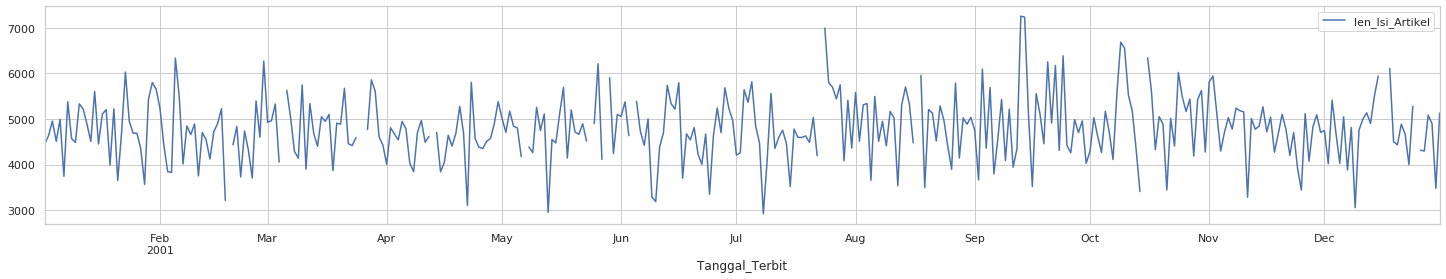

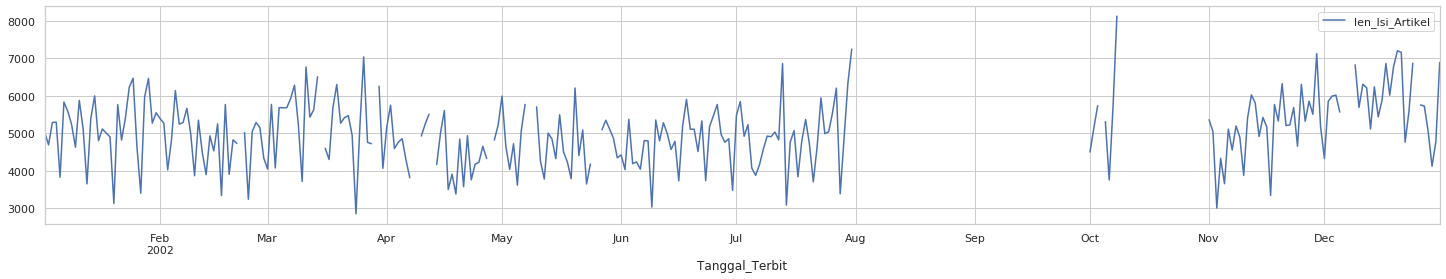

In [33]:
trend=lenartikel_day2001_mean.plot(figsize=(25, 4))
trend=lenartikel_day2002_mean.plot(figsize=(25, 4))

plt.show()

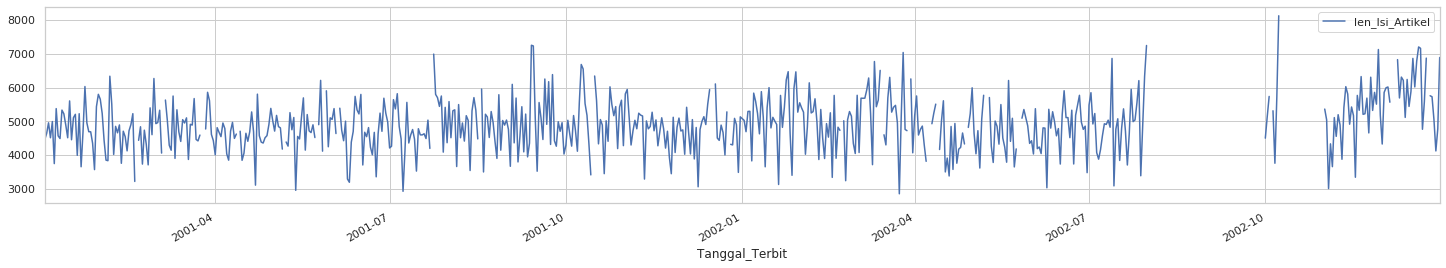

In [35]:
lenartikel_daycombine_mean=lenartikel_day2001_mean.append(lenartikel_day2002_mean)
trend=lenartikel_daycombine_mean.plot(figsize=(25, 4))

Dapat dilihat bahwa masih terdapat beberapa bagian yang terputus, mengindikasikan bahwa ada beberapa hari (bulan pada bagian 2020) yang tidak terisi.<br><br>

### Impute data

_credit :https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460_<br><br>

Untuk menyelesaikan masalah _Null Value_ pada data timeseries diatas, dapat dilakukan proses _impute_ data sebagai pengisi nilai data yang kosong.<br>
Untuk pembuatan model prediksi, saya akan melakukan _impute_ dengan metode _InterpolateTime_:

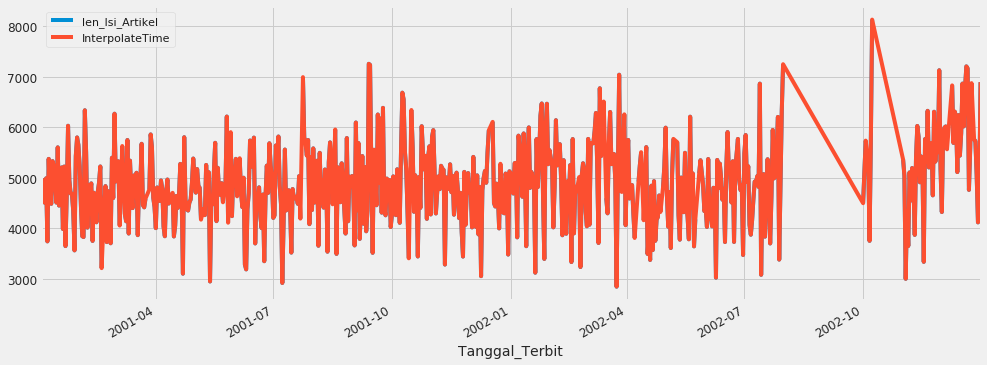

In [83]:
impute_df=pd.DataFrame()
impute_df = lenartikel_daycombine_mean.assign(InterpolateTime=lenartikel_daycombine_mean.len_Isi_Artikel.interpolate(method='time'))

impute_df.head()
impute_df.plot(figsize=(15, 6))

### Prediksi Data hasil _impute_

_credit : https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b_<br><br>

Metode prediksi data timeseries yang akan saya gunakan adalah **ARIMA**. ARIMA memiliki 3 hyperparameter yaitu ARIMA(p,d,q).<br>
Untuk menemukan hyper parameter yang sesuai dengan data set yang diujikan :

In [0]:
impute_df=impute_df['InterpolateTime']

In [89]:
#credit to :
#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14486.817286703408
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13795.328372362314
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:12091.03351303621
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11549.481593888508
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:12102.715625517802
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11810.917022379757
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11772.650261025134
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11548.472218566629
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13981.06774315893
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12921.298423971579
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11998.52492774363
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11466.084430135015
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12022.075968088824
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11688.985917210084
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11691.214740553361
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11463.098857041012
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12021.766667650303
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11828.61136741

Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA

In [104]:
mod = sm.tsa.statespace.SARIMAX(impute_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0661      0.045      1.486      0.137      -0.021       0.153
ma.L1         -0.8181      0.028    -29.627      0.000      -0.872      -0.764
ar.S.L12      -0.0658      0.043     -1.524      0.128      -0.150       0.019
ma.S.L12      -1.0007      0.745     -1.343      0.179      -2.462       0.460
sigma2      5.853e+05   4.46e+05      1.311      0.190    -2.9e+05    1.46e+06


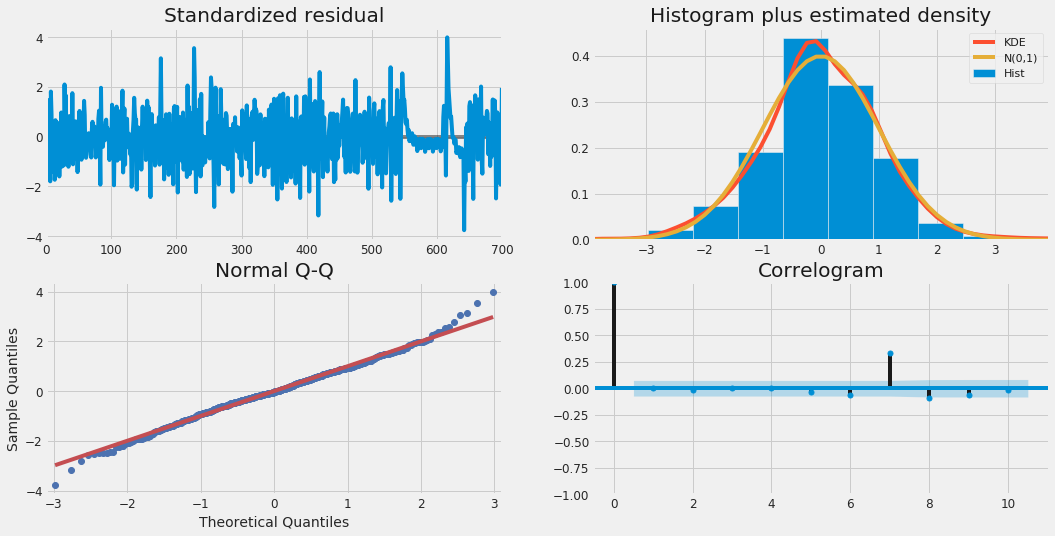

In [105]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

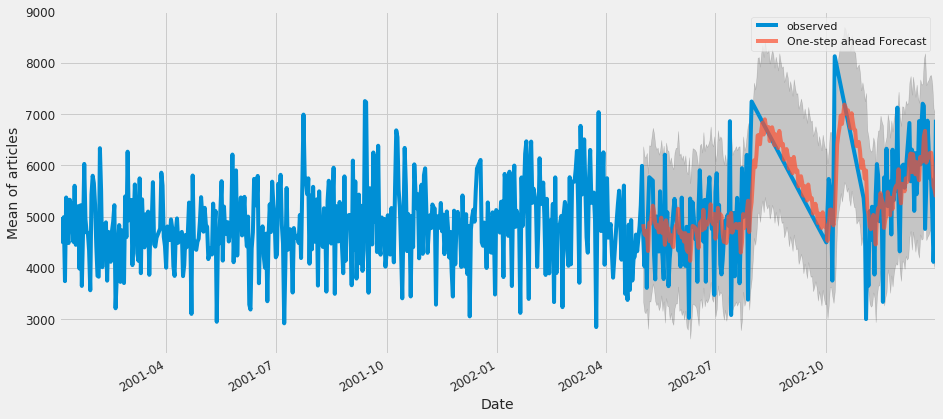

In [110]:
pred = results.get_prediction(start=pd.to_datetime('2002-05-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_df['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

Pada gambar grafik dapat dilihat bahwa prediksi meleset jauh dari kenyataannya. Untuk lebih pastinya, value **RMSE** dapat dilihat seperti berikut

In [111]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_df['2002-05-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi pertama : ',rmse)

RMSE dari prediksi pertama :  768.6387210471589


### **_Bagaimana bila bulan Desember 2002 tidak disertakan dalam pembuatan model?_**

In [0]:
impute_nodes2020=impute_df[:'2002-11-30']

In [113]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_nodes2020, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13857.91742248379
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13187.94394976307
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11578.222241387346
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11043.10137387885
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11589.433692025272
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11307.923577051155
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11261.41146664011
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11041.929656809018
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13373.733495549466
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12355.375205443534
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11489.895486050464
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10965.273920508665
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11512.965756721605
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11191.385222360226
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11186.642746185837
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10962.496404433245
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11510.715291050634
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11317.675979340

Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA

In [114]:
mod = sm.tsa.statespace.SARIMAX(impute_nodes2020,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0475      0.045      1.051      0.293      -0.041       0.136
ma.L1         -0.8093      0.029    -27.974      0.000      -0.866      -0.753
ar.S.L12      -0.0802      0.043     -1.886      0.059      -0.164       0.003
ma.S.L12      -1.0005      0.047    -21.475      0.000      -1.092      -0.909
sigma2      5.832e+05   7.87e-08   7.41e+12      0.000    5.83e+05    5.83e+05


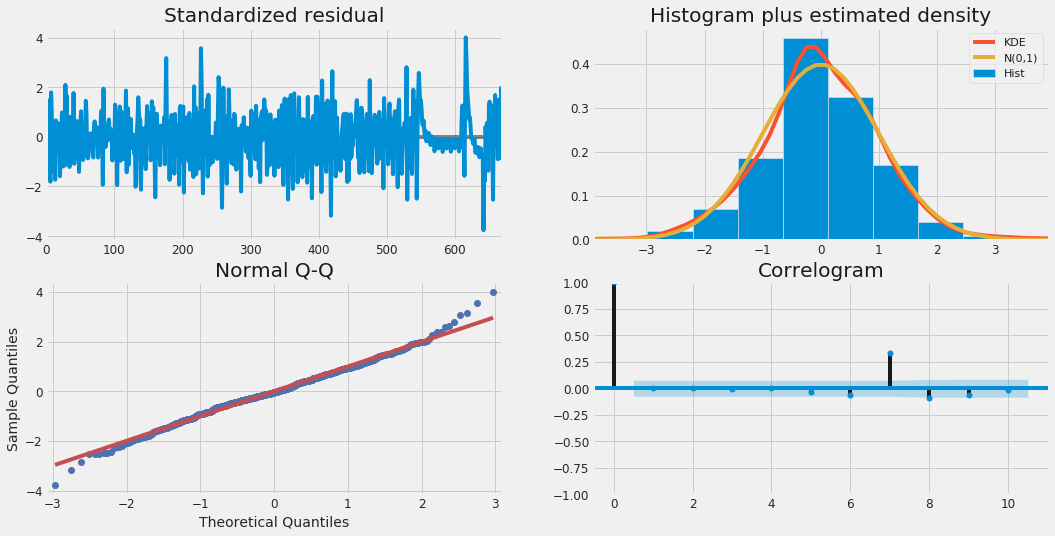

In [115]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

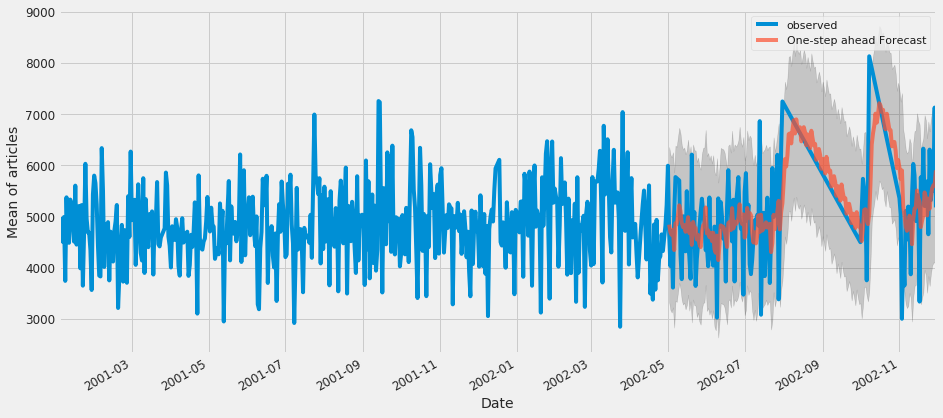

In [116]:
pred = results.get_prediction(start=pd.to_datetime('2002-05-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_nodes2020['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

**RMSE:**

In [119]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_nodes2020['2002-05-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi kedua : ',rmse)

RMSE dari prediksi kedua :  764.123415752567


### **_Bila bulan Agustus dan September diasumsikan memiliki nilai yang segnifikan. Bagaimana bila perhitungan prediksi hanya dilakukan hingga bulan Juli 2002?_**

In [0]:
impute_tillJul=impute_df[:'2002-7-31']

In [125]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_tillJul, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11384.646142142356
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10794.936677155063
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9443.524375839972
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8898.638047088889
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9455.787896119135
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9174.65403530515
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9094.643646931037
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:8900.921453760051
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10751.921718012029
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10141.43888768816
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9413.492789298703
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8883.383006983146
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9439.823807286912
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9123.307894376256
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:9086.586766944129
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8884.692366484309
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:9552.591547126243
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:9359.06709100744
ARIMA(0, 

Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA

In [126]:
mod = sm.tsa.statespace.SARIMAX(impute_tillJul,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0562      0.042      1.351      0.177      -0.025       0.138
ma.L1         -1.0201      0.012    -84.592      0.000      -1.044      -0.996
ar.S.L12      -0.0719      0.046     -1.565      0.118      -0.162       0.018
ma.S.L12      -1.0009      0.060    -16.625      0.000      -1.119      -0.883
sigma2       5.37e+05    1.1e-07   4.87e+12      0.000    5.37e+05    5.37e+05


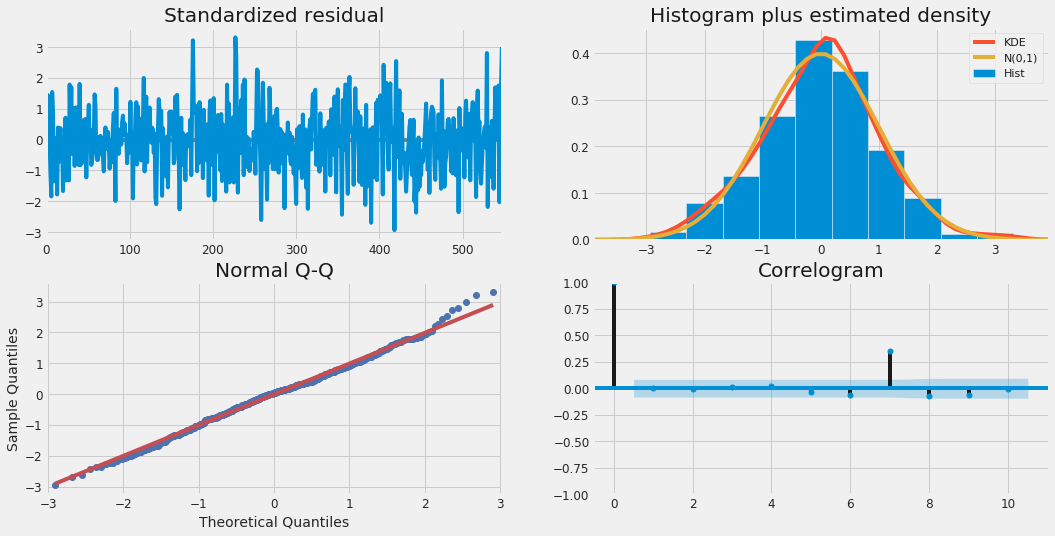

In [127]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

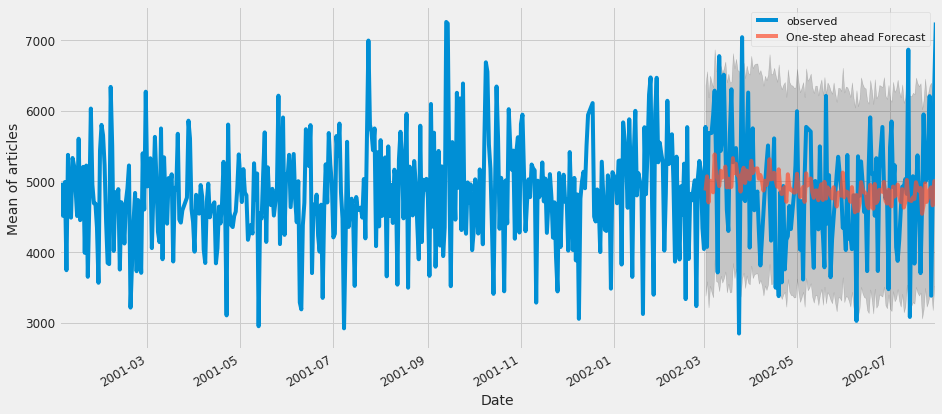

In [129]:
pred = results.get_prediction(start=pd.to_datetime('2002-03-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_tillJul['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

**RMSE:**

In [131]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_tillJul['2002-03-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi ketiga : ',rmse)

RMSE dari prediksi ketiga :  817.2520396309494


##**(Kesimpulan dari jawaban ke-3 berdasarkan hasil prediksi)**

Prediksi timeseries menggunakan metode ARIMA dengan 3 alternatif memberikan gambaran sebagai berikut:

1. Keseluruhan dataframe hasil impute (RMSE = 768.6387210471589)
2. Dataframe tanpa bulan Desember 2002 (RMSE = 764.123415752567)
3. Dataframe dari Januari 2001 hingga Juli 2002 (RMSE = 817.2520396309494)<br>

Dari hasil RMSE diatas, kita dapat mengetahui bahwa penghapusan data rata-rata panjang artikel bulan Desember 2002 tidak membawa pengaruh yang cukup segnifikan terhadap model yang dibuat (meskipun RMSE turun sedikit).<br>
Sebaliknya, dengan membuat model dengan dataframe hingga Juli 2002 (dengan harapan hasil impute masih dapat merepresentasikan kondisi sesungguhnya) justu membuat nilai RMSE melonjak.<br>

Berdasarkan dari dataset yang ada, meskipun rata panjang artikel memiliki korelasi antara tahun 2001 dan 2002, **tidak ditemukan** adanya menemukan pola yang segnifikan bila diamati rata-rata perharinya. Hal tersebut yang menyebabkan hasil prediksi memiliki nilai error yang cukup tinggi terlepas dengan variasi pemotongan dataframe yang dilakukan.

#Untuk pengembangan lebih lanjut

Tujuan utama dari analisa ini adalah untuk menemukan pola-pola khusus yang dinilai dapat membantu publisher baru dalam menentukan artikel berita yang harus mereka terbitkan, baik dari sisi panjang artikel maupun frekuensi keluarnya artikel dengan tema yang sama dalam satu hari seperti yang banyak ditemui di media besar.<br><br>
Masih banyak hal yang dapat dieksplorasi terkait dengan data artikel media masa online bila beberapa atribut lain dapat diketahui seperti :

1. Kernel jenis berita
2. Editor
3. Reporter
4. Jam publish
5. Jumlah Pembaca
6. Komentar<br>

Selain dari keterbatasannya data yang tersedia, juga masih banyak ditemui nilai _Null_ yang bisa jadi membawa arah analisa ke pola tertentu yang bisa ditemukan dan membantu dalam proses pembuatan model timeseries analisis. Diharapkan untuk projek analisis selanjutnya terkait artikel berita ada baiknya untuk melengkapi dataset dengan kriteria-kriteria yang disebutkan diatas